# Prepare Data

## Imports and Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from helper_code import *
from sklearn.preprocessing import StandardScaler
import time
import math
import seaborn as sns
from sklearn.model_selection import train_test_split

## Train Test Split
The dataset here only has the filenames of each recording, and the tf.Dataset object will load the recording itself during the training to make the training memory efficient

In [2]:
full_df = pd.read_csv("full_dataset.csv")
full_df

,Recording,Afib,Afl,MI,SVT,DB
0,data/cpsc/A4924.mat,0,0,0,0,CP
1,data/cpsc/A2054.mat,0,0,0,0,CP
2,data/cpsc/A5391.mat,0,0,0,0,CP
3,data/cpsc/A3580.mat,0,0,0,0,CP
4,data/cpsc/A4948.mat,0,0,0,0,CP
...,...,...,...,...,...,...
85738,data/ningbo/JS32861.mat,0,0,0,0,NI
85739,data/ningbo/JS41305.mat,0,0,0,0,NI
85740,data/ningbo/JS25189.mat,0,0,0,0,NI
85741,data/ningbo/JS42616.mat,0,0,0,0,NI


In [5]:
train_df, val_df = train_test_split(full_df, test_size=0.2, random_state=42)

In [6]:
# Ensure that the % of Afib and Afl is the same as the 20% train test split
print("% of Afib in test: {}".format(val_df['Afib'].sum()/full_df['Afib'].sum()))

% of Afib in test: 0.19802646333258578


## Visualize Data Augmentations
We increase the dataset with 3 augmentations:
1. Adding low freq sine wave as baseline wander
2. Adding 50Hz power line noise
3. Adding random gaussian noise

This is to make the model more robust to noise that might be present in real ECG data

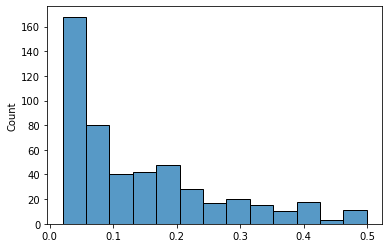

In [7]:
# Use loguniform so as to concentrate the randomness in the lower spectrum

from scipy.stats import loguniform

arr = []
for i in range(500):
    arr.append(loguniform.rvs(0.02, 0.5, size=None))
    
sns.histplot(data=arr)
plt.show()

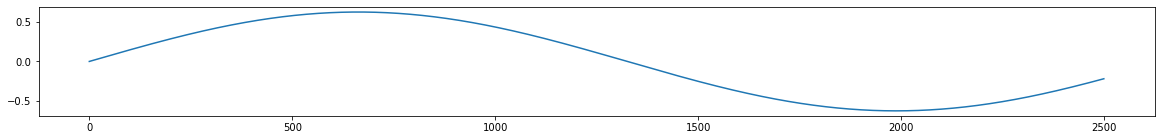

In [8]:
# Baseline Wander

def get_bw(qrs_amp):
    amp = np.random.rand() * 0.15 * qrs_amp      # Amplitude
    f = loguniform.rvs(0.02, 0.5, size=None)     # Frequency
    fs = 250                                     # Sample Rate
    t = 10

    x = np.arange(fs * t)
    y = [amp*np.sin(2 * np.pi * f * (i/fs)) for i in x]
    
    return np.array(y)

y = get_bw(6)

plt.figure(figsize=(20,2))
plt.plot(list(range(len(y))), y)

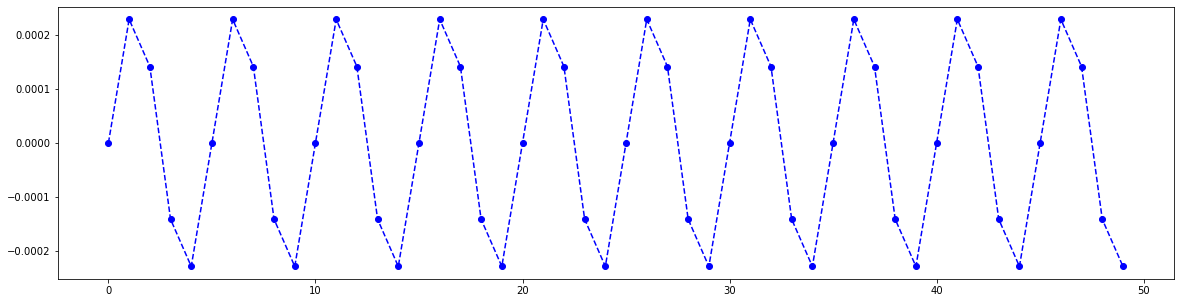

In [9]:
# Power Line

def get_pli(qrs_amp):
    amp = qrs_amp * 0.025 * np.random.rand()    # Amplitude
    f = 50     # Frequency
    fs = 250     # Sample Rate
    t = 10

    x = np.arange(fs * t)
    y = [amp*np.sin(2 * np.pi * f * (i/fs)) for i in x]
    
    return np.array(y)
    
y = get_pli(6.5)

plt.figure(figsize=(20,5))
plt.plot(list(range(len(y[:50]))), y[:50], '--bo')

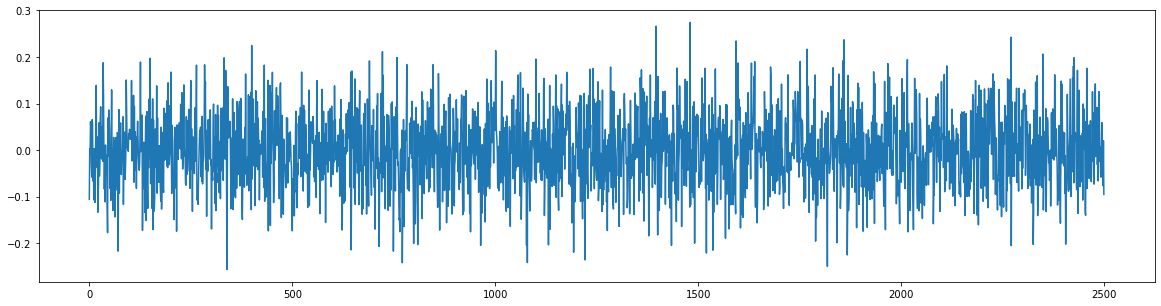

In [10]:
# Gaussian Noise

def get_gauss():
    gauss = np.random.normal(0, 0.08, (2500,))
    
    return gauss

gauss = get_gauss()

plt.figure(figsize=(20,5))
plt.plot(list(range(len(gauss))), gauss)

## Preprocess Signal

In [11]:
scaler = StandardScaler()
# filename = 'data/ptbxl/HR08056.mat' # normal
filename = 'data/chapman/JS06976.mat' # Afl

recording = load_recording(filename)
recording = recording.astype(np.float32).T
recording = recording[0:5000:2] # resample to 250Hz
print(recording.T.shape)
recording = scaler.fit_transform(recording) # Normalize

lead = recording.T

(12, 2500)


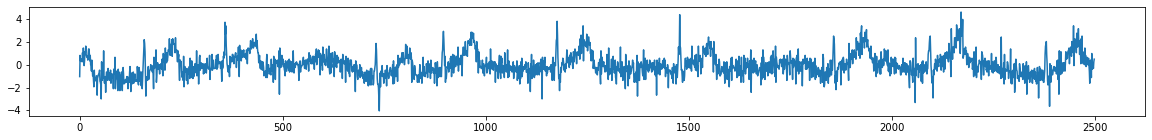

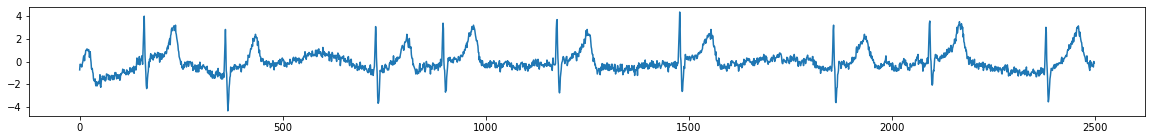

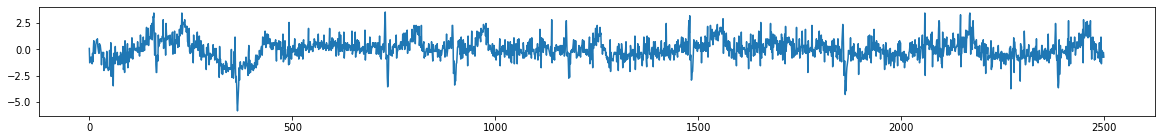

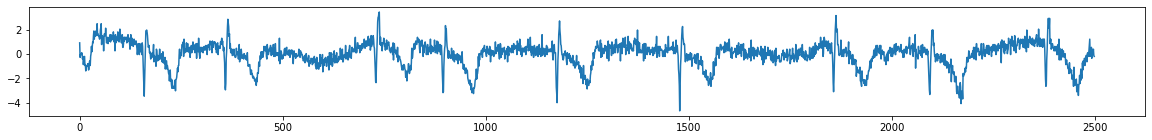

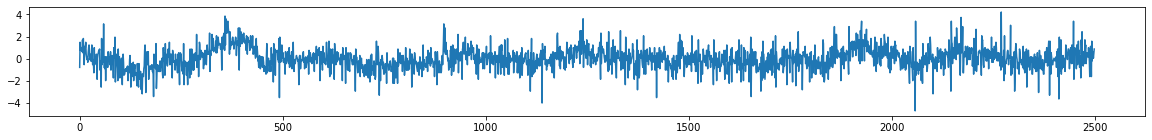

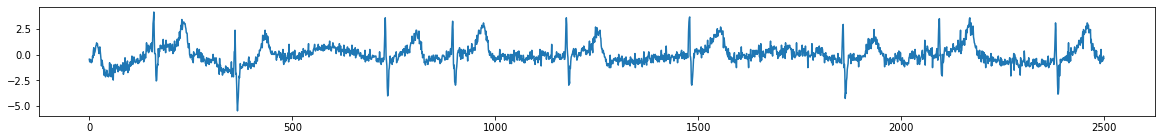

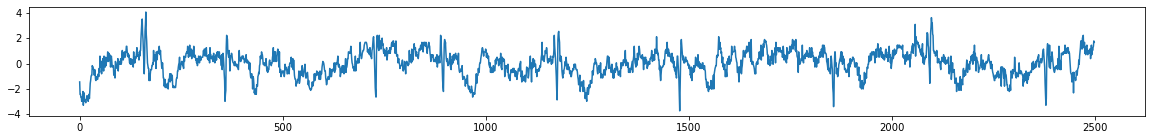

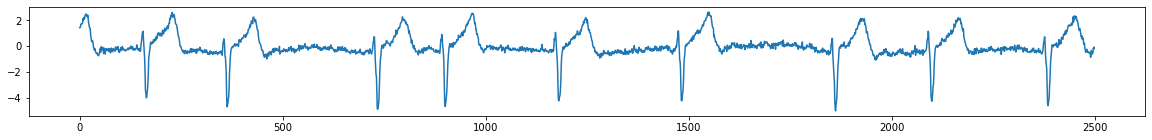

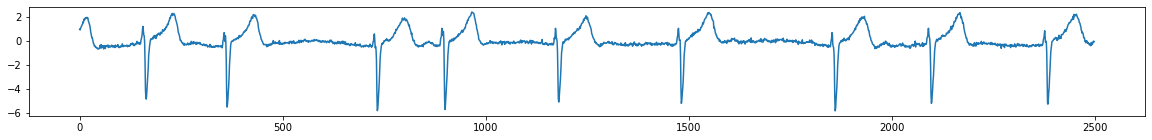

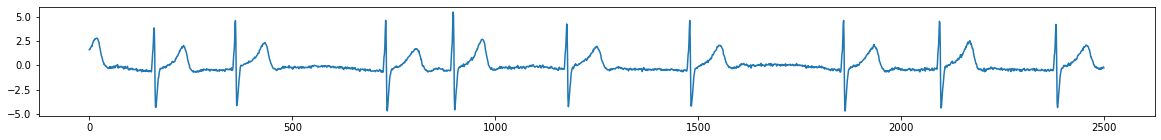

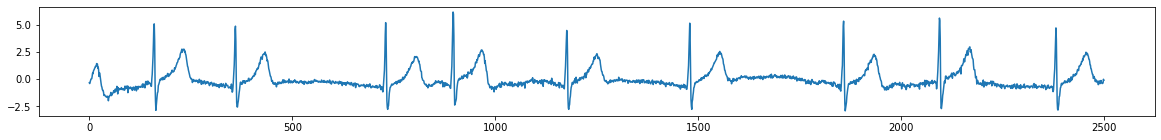

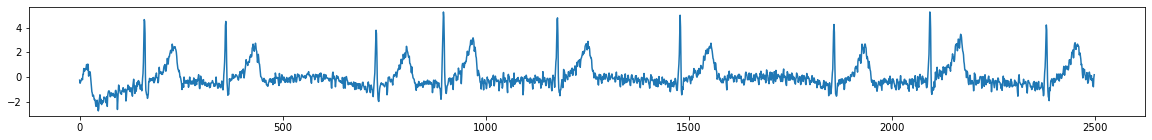

In [12]:
# visualisation of leads without augmentation

for i in range(12):
    plt.figure(figsize=(20,2))
    plt.plot(list(range(len(lead[i]))), lead[i])

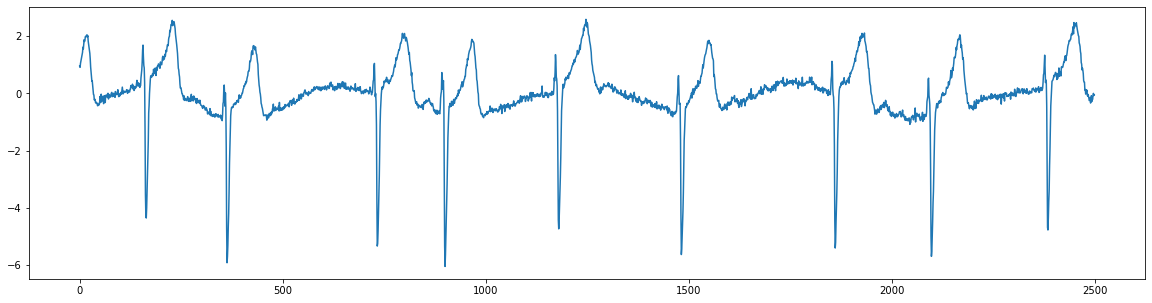

In [13]:
# visualisation of lead with baseline wander
lead_1 = lead[8] + get_bw(6)

plt.figure(figsize=(20,5))
plt.plot(list(range(len(lead_1))), lead_1)

In [14]:
def augment_leads(leads, aug_no):
    new_leads = []
    
    for lead in leads:
        qrs_amp = max(lead.max(), abs(lead.min()))
        
        if aug_no == 2:
            lead = lead + get_bw(qrs_amp)
        elif aug_no == 3:
            lead = lead + get_pli(qrs_amp)
        elif aug_no == 4:
            lead = lead + get_gauss()
        
        new_leads.append(lead)
    
    return np.array(new_leads)

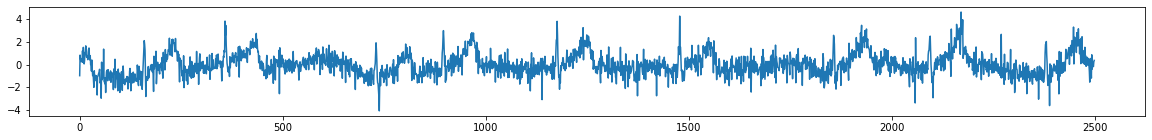

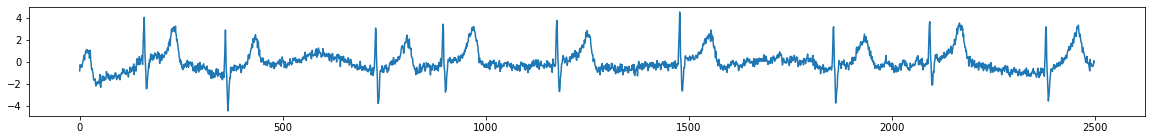

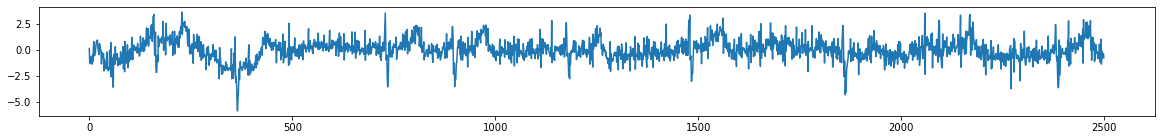

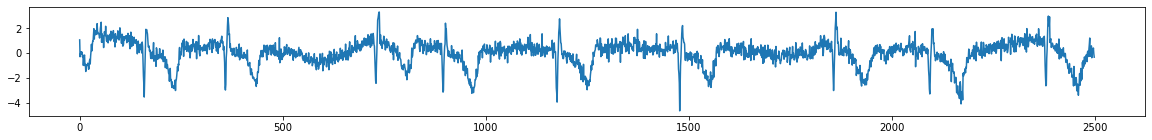

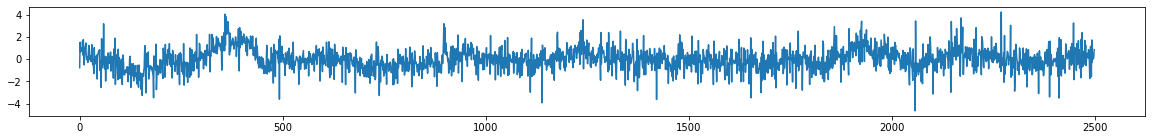

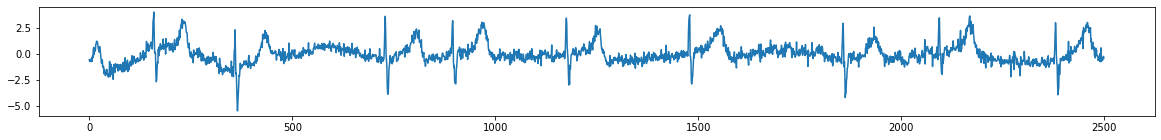

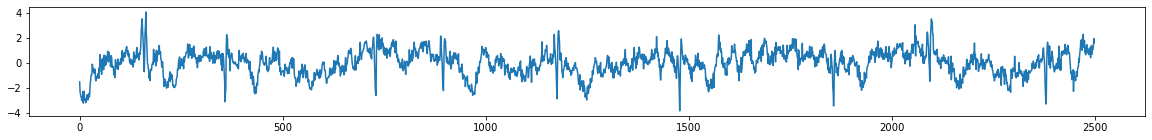

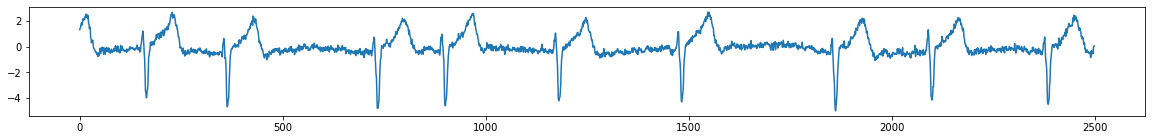

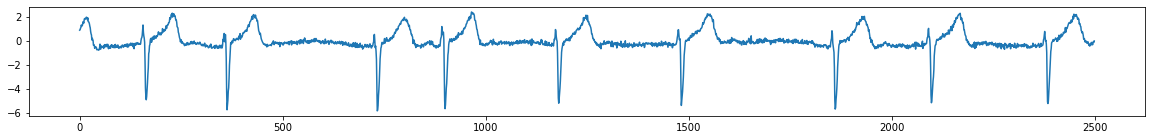

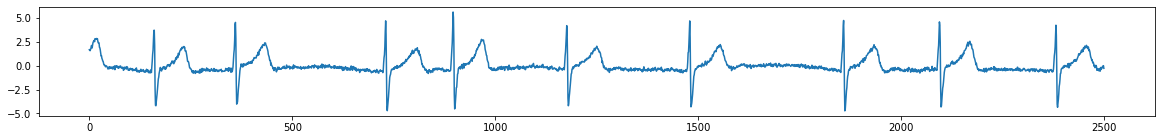

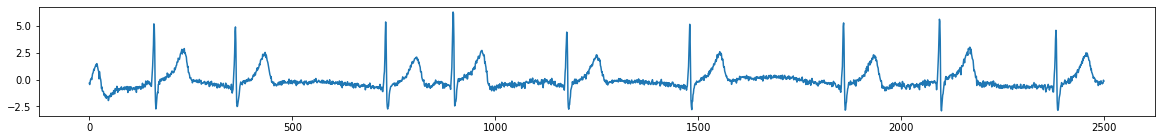

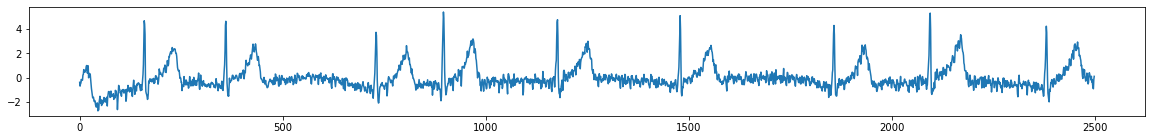

In [16]:
# visualisation of leads with augmentation

lead = augment_leads(lead, 4)

for i in range(12):
    plt.figure(figsize=(20,2))
    plt.plot(list(range(len(lead[i]))), lead[i])

In [17]:
channels = []
channels.append(np.concatenate((lead[0][:625], lead[3][625:1250], lead[6][1250:1875], lead[9][1875:])))
channels.append(np.concatenate((lead[1][:625], lead[4][625:1250], lead[7][1250:1875], lead[10][1875:])))
channels.append(np.concatenate((lead[2][:625], lead[5][625:1250], lead[8][1250:1875], lead[11][1875:])))
channels.append(lead[1])

channels = np.array(channels)

In [18]:
channels.shape

(4, 2500)

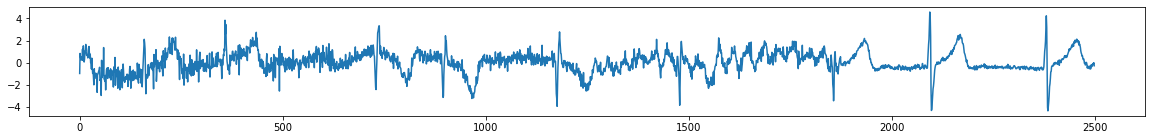

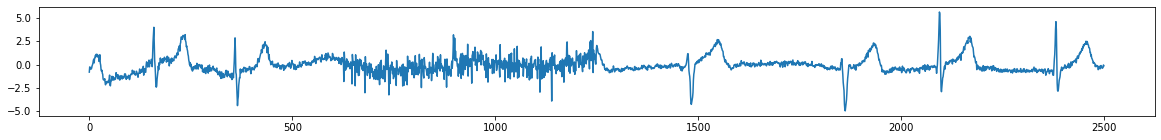

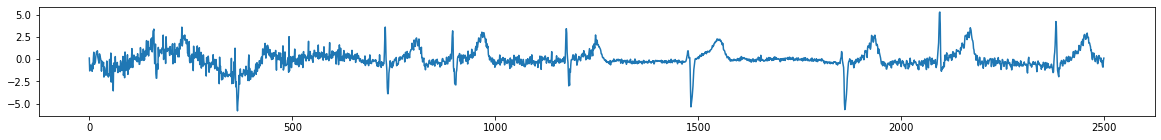

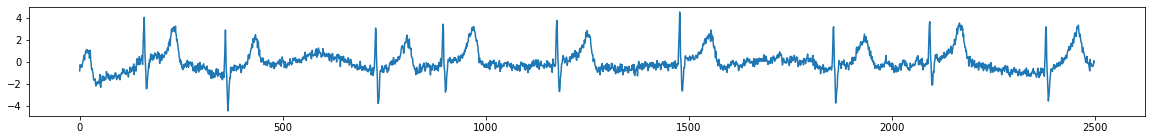

In [19]:
# final input to CNN (ecg with 12 leads but 4 channels)

for i in range(4):
    plt.figure(figsize=(20,2))
    plt.plot(list(range(len(channels[i]))), channels[i])

# Model for Afib

## Prepare Afib Data

In [20]:
afib_train = train_df[['Recording', 'Afib']]
afib_train

,Recording,Afib
81749,data/ningbo/JS34654.mat,0
48698,data/chapman/JS08234.mat,0
2899,data/cpsc/A4889.mat,1
26077,data/ptbxl/HR16287.mat,0
52440,data/ningbo/JS20129.mat,0
...,...,...
47486,data/chapman/JS04839.mat,0
6265,data/cpsc2/Q2234.mat,0
65178,data/ningbo/JS13632.mat,0
860,data/cpsc/A5399.mat,0


In [21]:
afib_train_F = afib_train[afib_train['Afib'] == 0]
afib_train_F

,Recording,Afib
81749,data/ningbo/JS34654.mat,0
48698,data/chapman/JS08234.mat,0
26077,data/ptbxl/HR16287.mat,0
52440,data/ningbo/JS20129.mat,0
59293,data/ningbo/JS41602.mat,0
...,...,...
47486,data/chapman/JS04839.mat,0
6265,data/cpsc2/Q2234.mat,0
65178,data/ningbo/JS13632.mat,0
860,data/cpsc/A5399.mat,0


In [22]:
afib_train_T = afib_train[afib_train['Afib'] == 1]
afib_train_T

,Recording,Afib
2899,data/cpsc/A4889.mat,1
42354,data/chapman/JS02137.mat,1
3570,data/cpsc/A4123.mat,1
40940,data/chapman/JS07903.mat,1
25499,data/ptbxl/HR11849.mat,1
...,...,...
5258,data/cpsc/A2783.mat,1
48336,data/chapman/JS06982.mat,1
21826,data/ptbxl/HR07073.mat,1
42898,data/chapman/JS07129.mat,1


In [23]:
# increase positive afib examples to reduce class imbalance
for i in range(9):
    afib_train_T = pd.concat([afib_train_T, afib_train[afib_train['Afib'] == 1]], ignore_index=True)
afib_train_T

,Recording,Afib
0,data/cpsc/A4889.mat,1
1,data/chapman/JS02137.mat,1
2,data/cpsc/A4123.mat,1
3,data/chapman/JS07903.mat,1
4,data/ptbxl/HR11849.mat,1
...,...,...
35755,data/cpsc/A2783.mat,1
35756,data/chapman/JS06982.mat,1
35757,data/ptbxl/HR07073.mat,1
35758,data/chapman/JS07129.mat,1


In [26]:
afib_train = pd.concat([afib_train_T, afib_train_F], ignore_index=True)
afib_train = afib_train.sample(frac=1).reset_index(drop=True)
afib_train

,Recording,Afib
0,data/ptbxl/HR13654.mat,1
1,data/cpsc/A6698.mat,1
2,data/chapman/JS03568.mat,1
3,data/ptbxl/HR10463.mat,1
4,data/chapman/JS07518.mat,1
...,...,...
92539,data/ningbo/JS23230.mat,0
92540,data/cpsc2/Q0102.mat,0
92541,data/chapman/JS02110.mat,0
92542,data/ningbo/JS19071.mat,0


In [27]:
x_train = np.array(afib_train['Recording'])
x_train

array(['data/ptbxl/HR13654.mat', 'data/cpsc/A6698.mat',
       'data/chapman/JS03568.mat', ..., 'data/chapman/JS02110.mat',
       'data/ningbo/JS19071.mat', 'data/cpsc/A6075.mat'], dtype=object)

In [28]:
y_train = np.array(afib_train[['Afib']])
y_train.shape

(92544, 1)

In [29]:
x_val = np.array(val_df['Recording'])
x_val

array(['data/ningbo/JS33233.mat', 'data/chapman/JS01662.mat',
       'data/chapman/JS00049.mat', ..., 'data/ptbxl/HR03867.mat',
       'data/ptbxl/HR05057.mat', 'data/ptbxl/HR13550.mat'], dtype=object)

In [30]:
y_val = np.array(val_df[['Afib']])
y_val.shape

(15091, 1)

## Dataset Prep

Use tf.data.Dateset as a data loader for training

In [32]:
import tensorflow as tf
print(tf.__version__)

2.4.2


In [32]:
scaler = StandardScaler()

In [33]:
def get_ecg(filename, label):
    def process_mat(filename):
        recording = load_recording(filename)
        recording = recording.astype(np.float32).T
        recording = recording[0:5000:2] # resample to 250Hz
        recording = scaler.fit_transform(recording) # Normalize
        lead = recording.T
        
        # Random number from 1 to 6. 
        # 2, 3, 4 will have augmentations, 1, 5, 6, will be original
        lead = augment_leads(lead, np.random.randint(1, 7))
        
        channels = []
        channels.append(np.concatenate((lead[0][:625], lead[3][625:1250], lead[6][1250:1875], lead[9][1875:])))
        channels.append(np.concatenate((lead[1][:625], lead[4][625:1250], lead[7][1250:1875], lead[10][1875:])))
        channels.append(np.concatenate((lead[2][:625], lead[5][625:1250], lead[8][1250:1875], lead[11][1875:])))
        channels.append(lead[1])
        channels = np.array(channels)
        
        return channels.astype(np.float32).T
        
    recording = tf.numpy_function(process_mat, [filename], [tf.float32])
    recording = tf.reshape(recording, (2500, 4))

    return recording, label

In [34]:
def get_val(filename, label):
    def process_mat(filename):
        recording = load_recording(filename)
        recording = recording.astype(np.float32).T
        recording = recording[0:5000:2] # resample to 250Hz
        recording = scaler.fit_transform(recording) # Normalize
        lead = recording.T
        
        channels = []
        channels.append(np.concatenate((lead[0][:625], lead[3][625:1250], lead[6][1250:1875], lead[9][1875:])))
        channels.append(np.concatenate((lead[1][:625], lead[4][625:1250], lead[7][1250:1875], lead[10][1875:])))
        channels.append(np.concatenate((lead[2][:625], lead[5][625:1250], lead[8][1250:1875], lead[11][1875:])))
        channels.append(lead[1])
        channels = np.array(channels)
        
        return channels.T
        
    recording = tf.numpy_function(process_mat, [filename], [tf.float32])
    recording = tf.reshape(recording, (2500, 4))

    return recording, label

In [35]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.map(get_ecg)
train_dataset = train_dataset.shuffle(5000)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(64, drop_remainder=True)

In [36]:
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.map(get_val)
val_dataset = val_dataset.repeat()
val_dataset = val_dataset.batch(64, drop_remainder=True)

In [37]:
train_dataset, val_dataset

(<BatchDataset shapes: ((64, 2500, 4), (64, 1)), types: (tf.float32, tf.int64)>,
 <BatchDataset shapes: ((64, 2500, 4), (64, 1)), types: (tf.float32, tf.int64)>)

## Model Building and Training

In [43]:
from tensorflow.keras.layers import Input, Dense, Conv1D, BatchNormalization, AveragePooling1D
from tensorflow.keras.layers import ReLU, Add, MaxPool1D, GlobalAvgPool1D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

In [44]:
def Conv_BatchNorm(x, filters, kernel_size, strides):
    x = Conv1D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', kernel_regularizer=l2(0.03))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.5)(x)
    return x

In [45]:
def resnet_block(orig_x, num_filters, kernel_size, strides):
    x1 = Conv_BatchNorm(orig_x, filters=num_filters, kernel_size=kernel_size, strides=strides)
    x1 = Conv_BatchNorm(x1, filters=num_filters, kernel_size=kernel_size, strides=1)
    
    x2 = AveragePooling1D(pool_size=2, strides=strides, padding='same')(orig_x)
    x2 = Conv1D(filters=num_filters, kernel_size=1, strides=1, padding='same')(x2)
 
    x = Add()([x1, x2])
    return x

In [47]:
Inp = Input(shape=(2500, 4),name="Inp")
 
x = Conv_BatchNorm(Inp, filters=64, kernel_size=9, strides=2)  
x = MaxPool1D(pool_size=5, strides=2, padding='same')(x)

x = resnet_block(x, num_filters=64, kernel_size=3, strides=2)
x = resnet_block(x, num_filters=128, kernel_size=3, strides=2)
x = resnet_block(x, num_filters=256, kernel_size=3, strides=2)
 
x = GlobalAvgPool1D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(1, activation='sigmoid')(x)
 
model = Model(Inp, output, name='simple-res')

In [48]:
model.summary()

Model: "simple-res"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inp (InputLayer)                [(None, 2500, 4)]    0                                            
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 1250, 64)     2368        Inp[0][0]                        
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 1250, 64)     256         conv1d_10[0][0]                  
__________________________________________________________________________________________________
re_lu_7 (ReLU)                  (None, 1250, 64)     0           batch_normalization_7[0][0]      
_________________________________________________________________________________________

In [50]:
opt = tf.keras.optimizers.Adam(learning_rate=0.00005)
bce = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.25) # label smoothing to prevent large weights

model.compile(optimizer=opt, loss=bce, metrics=['accuracy'])

In [51]:
filepath="afib_checkpoints/weights-{epoch:02d}.hdf5"
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(filepath, verbose=1, save_weights_only=True)

In [52]:
model.fit(train_dataset,
          steps_per_epoch = int(92544/64),
          epochs=30,
#           validation_data = val_dataset,
#           validation_steps = int(640/64),
          class_weight={0:1.0, 1:2.0},
          callbacks=[checkpoint_cb]
          )

Epoch 1/30
1446/1446 [==============================] - 2372s 2s/step - loss: 34.8541 - accuracy: 0.5579

Epoch 00001: saving model to afib_checkpoints/weights-01.hdf5
Epoch 2/30
1446/1446 [==============================] - 2240s 2s/step - loss: 3.0451 - accuracy: 0.8390

Epoch 00002: saving model to afib_checkpoints/weights-02.hdf5
Epoch 3/30
1446/1446 [==============================] - 2251s 2s/step - loss: 0.9934 - accuracy: 0.8876

Epoch 00003: saving model to afib_checkpoints/weights-03.hdf5
Epoch 4/30
1446/1446 [==============================] - 2246s 2s/step - loss: 0.7717 - accuracy: 0.8907

Epoch 00004: saving model to afib_checkpoints/weights-04.hdf5
Epoch 5/30
1446/1446 [==============================] - 2229s 2s/step - loss: 0.7290 - accuracy: 0.8944

Epoch 00005: saving model to afib_checkpoints/weights-05.hdf5
Epoch 6/30
1446/1446 [==============================] - 2208s 2s/step - loss: 0.7158 - accuracy: 0.8953

Epoch 00006: saving model to afib_checkpoints/weights-06.hd

KeyboardInterrupt: 

In [113]:
model.load_weights("afib_checkpoints/weights-18.hdf5")
model.compile(optimizer=opt, loss=bce, metrics=['accuracy'])

## Results

Precision = Out of all cases that are PREDICTED as positive, how many of them are ACTUALLY positive

Recall = Out of all cases that are ACTUALLY positive, how many of them are PREDICTED as positive

True Positive Rate = if a patient actually has Afib, how many percent of the time will the algorithm identify that he has Afib

False Positive Rate = if a patient actually does NOT have Afib, how many percent of the time will the algorithm say that he has Afib

### Train Results

In [114]:
from sklearn.metrics import confusion_matrix
from cf_matrix import make_confusion_matrix

In [116]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.map(get_val)
train_dataset = train_dataset.batch(64, drop_remainder=False)

In [117]:
y_pred = model.predict(train_dataset)
y_pred

array([[0.831609  ],
       [0.73942965],
       [0.7022715 ],
       ...,
       [0.04103098],
       [0.08651938],
       [0.8850297 ]], dtype=float32)

In [119]:
afib_true = y_train.T[0]
afib_pred = y_pred.T[0]

afib_pred = np.around(afib_pred).astype(np.int)

In [120]:
cf_m = confusion_matrix(afib_true, afib_pred)
cf_m

array([[48382,  8402],
       [ 1500, 34260]])

True Postive Rate: 0.9580536912751678
False Postive Rate: 0.1479642152719076


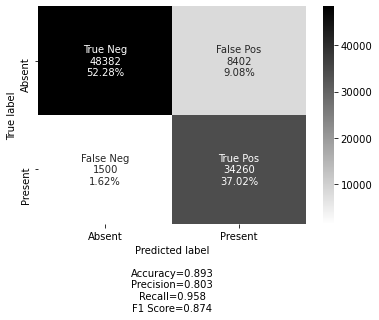

In [122]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Absent', 'Present']
make_confusion_matrix(cf_m,
                      group_names=labels,
                      categories=categories,
                      cmap='binary')

print('True Postive Rate: {}'.format(cf_m[1][1]/(cf_m[1][0] + cf_m[1][1])))
print('False Postive Rate: {}'.format(cf_m[0][1]/(cf_m[0][0] + cf_m[0][1])))

### Test Results

In [123]:
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.map(get_val)
val_dataset = val_dataset.batch(64, drop_remainder=False)

In [124]:
y_pred = model.predict(val_dataset)
y_pred

array([[0.07754366],
       [0.04223796],
       [0.09409272],
       ...,
       [0.20252648],
       [0.5680688 ],
       [0.13173951]], dtype=float32)

In [128]:
afib_true = y_val.T[0]
afib_pred = y_pred.T[0]

afib_pred = np.around(afib_pred).astype(np.int)

In [129]:
cf_m = confusion_matrix(afib_true, afib_pred)
cf_m

array([[12032,  2176],
       [   44,   839]])

True Postive Rate: 0.9501698754246886
False Postive Rate: 0.15315315315315314


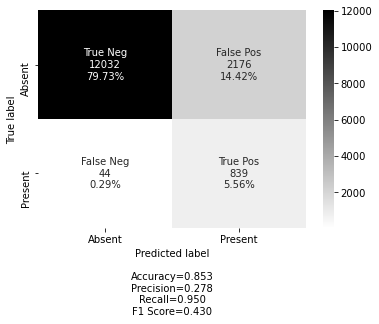

In [130]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Absent', 'Present']
make_confusion_matrix(cf_m,
                      group_names=labels,
                      categories=categories, 
                      cmap='binary')

print('True Postive Rate: {}'.format(cf_m[1][1]/(cf_m[1][0] + cf_m[1][1])))
print('False Postive Rate: {}'.format(cf_m[0][1]/(cf_m[0][0] + cf_m[0][1])))

## Save and Load Model

In [131]:
model.save('afib_model.h5')
loaded_model = tf.keras.models.load_model('afib_model.h5')